# Building the Recommendation system

In this notebook, I am building a table for the consine dist for both content

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_selection.variance_threshold import VarianceThreshold
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv
from collections import Counter

# Content: 

Import Game Meta Data

In [2]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./game_meta_data/') if isfile(join('./game_meta_data/', f))] #get list of files
list_of_meta = [] # fill this list with dictionaries 
feature_list = ['guid', 'name', 'concepts', 'themes', 'deck', 'developers', 'publishers', 'genres'] #list of features I care about
for file in onlyfiles:
    #looping through files, open them, put their contents into a dict, and add it to the list
    with open(f'./game_meta_data/{file}', 'r') as f:
        game = json.load(f)
        game_dict = {key:value for key, value in game.items() if key in feature_list}

        # convert lists to strings 
        for key, value in game_dict.items():
            if type(value) == list:
                game_dict[key] = ', '.join(value)
        list_of_meta.append(game_dict)
# make pandas dataframe
df = pd.DataFrame(list_of_meta)
df.fillna("", inplace=True)

## Here we have the raw data frame.  We need to:
* Dummy the columns 
* Drop features that are too sparse
* Drop games that have too few features

In [3]:
df.head()

,concepts,deck,developers,genres,guid,name,publishers,themes
0,"Achievements, PlayStation Trophies, Steam, Dig...",Kill The Bad Guy is a puzzle-game where physic...,Exkee,"Strategy, Simulation",3030-46539,Kill the Bad Guy,,
1,,Zeal is an indie online ARPG developed by Lyca...,Lycanic Studios,"Action, Role-Playing, MOBA",3030-68714,Zeal,,"Fantasy, Medieval"
2,,Vertical Drop Heroes HD is an action platformer.,Nerdook Productions,"Action, Role-Playing, Platformer",3030-48249,Vertical Drop Heroes HD,,Fantasy
3,"Unreal Engine 4, PlayStation VR Support",A puzzle mystery game for PS VR.,Tarsier Studios,Puzzle,3030-57976,Statik,,
4,,A compilation of all three Banner Saga titles.,Stoic,"Strategy, Role-Playing, Compilation",3030-68731,The Banner Saga Trilogy,,Fantasy


In [4]:
def split_features_from_col(df, col):
    '''
    Returns a dataframe of 1 hot encoded features from the selected col 
    '''
    df[col] = ['' if entry == None else entry for entry in df[col] ]
    cvec = CountVectorizer(stop_words='english', tokenizer=lambda x: x.split(', '))
    bow = cvec.fit_transform(df[col])
    ret_df  = pd.DataFrame(bow.todense(),
                       columns=map(lambda x: col + "_" + x, cvec.get_feature_names()))
    ret_df.drop(col+'_', 1, inplace=True)
    return ret_df

def split_features(df, list_of_cols):
    '''
    Returns a dataframe of 1 hot encoded features from a list of cols
    '''
    ret_df = df.loc[:, ['name', 'guid']]
    for col in list_of_cols:
        ret_df = pd.merge(ret_df, split_features_from_col(df, col), left_index=True, right_index=True)
        
    return ret_df

In [5]:
# We have 4 features that we want to split
dummied_df = split_features(df, ['concepts', 'genres', 'themes', 'developers'])

In [6]:
dummied_df.shape

(1746, 5072)

##  Manual Feature Reduction

In [7]:
dummied_df.var().sort_values(ascending=False)[0:20]

concepts_digital distribution    0.236484
concepts_steam                   0.193403
themes_fantasy                   0.171660
genres_action                    0.169722
themes_sci-fi                    0.154435
concepts_indie                   0.128014
concepts_steam achievements      0.127613
genres_adventure                 0.114020
genres_role-playing              0.111472
concepts_achievements            0.108037
genres_platformer                0.104998
genres_action-adventure          0.104123
concepts_playstation trophies    0.102367
concepts_steam trading cards     0.100156
concepts_gog.com                 0.097034
concepts_2d                      0.093879
concepts_voice acting            0.090693
themes_comedy                    0.088397
concepts_male protagonists       0.084689
genres_puzzle                    0.081881
dtype: float64

I don't want features like concepts_digital distribution or concepts_steam.\* or concepts_pax.\* or concepts_e3.\*

In [8]:
drop_cols = ["concepts_digital distribution"]
for col in dummied_df.columns:
    if ("concepts_steam" in col) or ("concepts_pax" in col) or ("concepts_e3" in col):
        drop_cols.append(col)
drop_cols[0:10]
print(f"Dropping {len(drop_cols)} columns")

Dropping 54 columns


In [9]:
dummied_df.drop(drop_cols, 1, inplace=True)

### Dropping games with too few (5 or less) features

In [10]:
thresh = 6
(dummied_df.iloc[:,2:].T.sum()>=thresh).sum()

1097

In [11]:
dummied_df.drop(dummied_df[dummied_df.iloc[:,2:].T.sum()<thresh].index, 0, inplace=True)

In [12]:
dummied_df.set_index("name", inplace=True)

In [13]:
dummied_df.drop("guid", 1, inplace=True)

In [14]:
dummied_df.shape

(1097, 5016)

## Using Sklearn's Variance Threshold to drop features with variance of .005 and less

In [15]:
vt = VarianceThreshold(.005)
thresh_df = vt.fit_transform(dummied_df)

In [16]:
thresh_df.shape

(1097, 1214)

## Using TruncatedSVD to condense 1214 features into 150 components.  
150 components explains 74% of the variance

In [17]:
svd = TruncatedSVD(n_components=150)
content = svd.fit_transform(thresh_df)

<Container object of 150 artists>

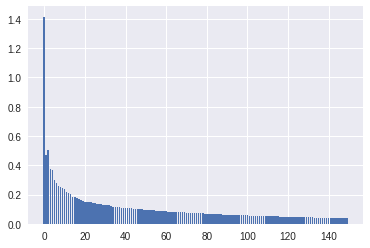

In [18]:
plt.bar(range(150),svd.explained_variance_)

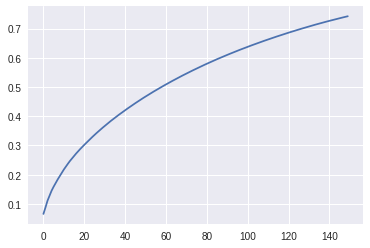

In [19]:
plt.plot(range(150), np.cumsum(svd.explained_variance_ratio_))

# Now to make the simularity matrix
* uses cosine distance
* simularity matrix stored in pandas dataframe called `distance_df`


In [20]:
sparse_content = sparse.csr_matrix(content)

In [21]:
distances = pairwise_distances(content, metric='cosine') 
distance_df = pd.DataFrame(distances, index=dummied_df.index, columns=dummied_df.index)
distance_df.head()

name,Kill the Bad Guy,Zeal,Giana Sisters: Twisted Dreams,Warriors All-Stars,Ultra Street Fighter IV,Arcania: Gothic 4,Lichdom: Battlemage,The King of Fighters Collection: The Orochi Saga,Alien Shooter,JumpJet Rex,...,Alienation,World Heroes 2 JET,Way of Redemption,Mystereet F: Tantei-tachi no Curtain Call,Hotline Miami 2: Wrong Number,The Magic Circle,Gran Turismo Sport,Guts and Glory,Mighty No. 9,Sonic Forces
name,,,,,,,,,,,,,,,,,,,,,
Kill the Bad Guy,0.000000,0.984854,0.820719,1.024092,0.868586,0.913612,0.987859,1.000790,0.979661,1.013405,...,0.992022,0.990302,0.985415,0.986773,0.977569,0.992358,1.032096,1.040443,0.917575,0.973354
Zeal,0.984854,0.000000,0.931720,0.491866,1.010024,0.768714,0.504344,1.010329,0.803300,1.016844,...,0.976963,1.001705,0.422917,0.991411,0.866036,0.795410,1.004279,0.982257,0.891096,0.816847
Giana Sisters: Twisted Dreams,0.820719,0.931720,0.000000,0.944992,0.829711,0.859967,0.921122,1.003701,0.953222,0.821423,...,0.886188,1.006228,0.909956,1.003195,0.882134,0.927619,1.037160,0.934407,0.710477,0.752584
Warriors All-Stars,1.024092,0.491866,0.944992,0.000000,0.921681,0.941183,0.736190,0.858389,0.888432,1.024581,...,1.037060,0.983754,0.464854,0.987844,0.851744,0.813249,1.011818,1.044860,0.937790,0.768492
Ultra Street Fighter IV,0.868586,1.010024,0.829711,0.921681,0.000000,0.913375,0.872066,0.787157,0.988340,0.886741,...,0.928659,0.757578,1.014756,0.937888,1.038304,0.958674,0.991172,0.985641,0.910743,0.995620


In [22]:
# Functions that interact with the content filter

def search_game(search):
    for title in [game for game in distance_df.columns if search.lower() in game.lower() ]:
#     for title in df.loc[df['name'].str.lower().str.contains(str.lower(search)), 'name'].values:
        if title in distance_df.columns:
            print(title)
            print()
            print('Similar Games:')
            for i in range(10):
                print(distance_df[title].sort_values(ascending=True).index[i+1])
            print()
            print()


def getSimilarFeatures(game1, game2):
    '''
    Prints the simularity score and common features between @param game1 and @param game2
    '''
    vec1 = dummied_df.loc[game1, :]
    vec2 = dummied_df.loc[game2, :] 
    
    common = vec1 & vec2
    common = common[common==1]

    print("Simularity Score:")
    print()
    print(distance_df.loc[game1, game2])
    print()
    
    print("Number of features:")
    print((vec1.sum(), vec2.sum()))
    print()
    
    print("Common features:")
    print()
    print(common)
    


In [23]:
search_game("Life is strange")

Life Is Strange

Similar Games:
Life Is Strange: Before the Storm
Bear With Me
Yu-No: Kono Yo no Hate de Koi o Utau Shoujo
The Legend of Korra
The Little Acre
Toren
Chaos;Child
Natsuiro High School: Seishun Hakusho
Murdered: Soul Suspect
Guardians of the Galaxy: The Telltale Series


Life Is Strange: Before the Storm

Similar Games:
Life Is Strange
The Walking Dead: Season Two
Observer
Indigo Prophecy
Beyond Eyes
The Wolf Among Us
N.E.R.O.: Nothing Ever Remains Obscure
Tsuki ni Yorisou Otome no Sahou
Toren
Raiders of the Broken Planet




In [24]:
getSimilarFeatures("Street Fighter V", "Ultra Street Fighter IV")

Simularity Score:

0.43089078267

Number of features:
(43, 88)

Common features:

concepts_charge                      1
concepts_command grab                1
concepts_elasticity                  1
concepts_hadouken                    1
concepts_karate                      1
concepts_kung fu                     1
concepts_mercenary                   1
concepts_negative edge               1
concepts_parrying                    1
concepts_playstation network         1
concepts_playstation trophies        1
concepts_revealing attire            1
concepts_sexualized women            1
concepts_shoryuken                   1
concepts_shun goku satsu             1
concepts_smashing into the screen    1
concepts_taito type x                1
concepts_taunting                    1
genres_fighting                      1
themes_martial arts                  1
developers_capcom                    1
developers_dimps corporation         1
dtype: int64


In [25]:
getSimilarFeatures( "Street Fighter V", "Kill the Bad Guy")

Simularity Score:

0.881188773644

Number of features:
(43, 7)

Common features:

concepts_playstation trophies    1
dtype: int64


In [26]:
# distance_df.to_csv("../sim_matrix.csv")

## Now to make multiple game search